In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential

In [3]:
# path to the files
train_dir = pathlib.Path('training_2 classes')
test_dir = pathlib.Path('testing_2 classes')

In [4]:
# to check if images are there
import os

train_dir = 'training_2 classes'
test_dir = 'testing_2 classes'

# List files in train directory
train_files = os.listdir(train_dir)
print(f"Files in training directory: {train_files}")

# List files in test directory
test_files = os.listdir(test_dir)
print(f"Files in testing directory: {test_files}")

Files in training directory: ['DEFICIENT', 'NORMAL']
Files in testing directory: ['DEFICIENT', 'NORMAL']


In [5]:
# Load the data
batch_size = 32
img_height = 180
img_width = 180


In [6]:
# splitting the dataset
train_ds_orig = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_orig = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 514 files belonging to 2 classes.
Using 412 files for training.
Found 514 files belonging to 2 classes.
Using 102 files for validation.
Found 178 files belonging to 2 classes.


In [7]:
class_names = train_ds_orig.class_names
num_classes = len(class_names)

In [8]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_orig.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Data Augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
         layers.RandomContrast(0.2),  # Add contrast augmentation(added)
        layers.RandomBrightness(0.2),  # Add brightness augmentation(added)

    ]
)

C:\Users\vedik\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Create the model
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),  # Feature Extraction Layer
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,162 (125.63 KB)

 Trainable params: 32,162 (125.63 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.5525 - loss: 0.6773 - val_accuracy: 0.5784 - val_loss: 0.6552
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - accuracy: 0.6419 - loss: 0.6174 - val_accuracy: 0.6569 - val_loss: 0.6373
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.6544 - loss: 0.6026 - val_accuracy: 0.6765 - val_loss: 0.5956
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.7681 - loss: 0.5533 - val_accuracy: 0.6961 - val_loss: 0.5411
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.7512 - loss: 0.5063 - val_accuracy: 0.7059 - val_loss: 0.5159
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.8078 - loss: 0.4835 - val_accuracy: 0.8137 - val_loss: 0.4593
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.8304 - loss: 0.4395 - val_accuracy: 0.7843 - val_loss: 0.4525
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.8388 - loss: 0.4081 - val_accuracy: 0.

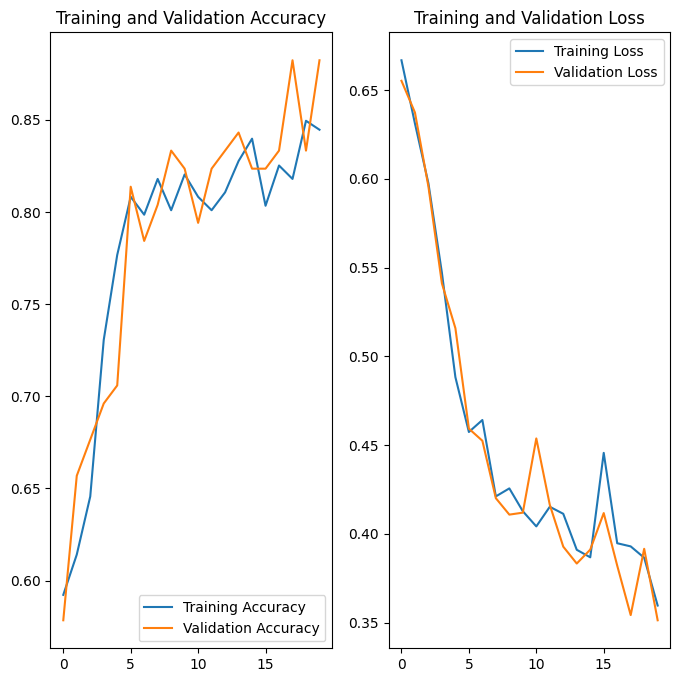

In [14]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [16]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import os

# Set your model and class_names here
# Example:
# model = ...
# class_names = [...]

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, img_height=224, img_width=224):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Function to predict the class of an image
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    return predicted_class, confidence

# Ask the user for the path to the test image
test_img_path = input("Please enter the path to your image: ").strip()

# Predict the class of the test image
predicted_class, confidence = predict_image(model, test_img_path)
print(f"This image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")


Please enter the path to your image:  photo.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
This image most likely belongs to NORMAL with a 83.77% confidence.


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

<Figure size 1000x800 with 0 Axes>

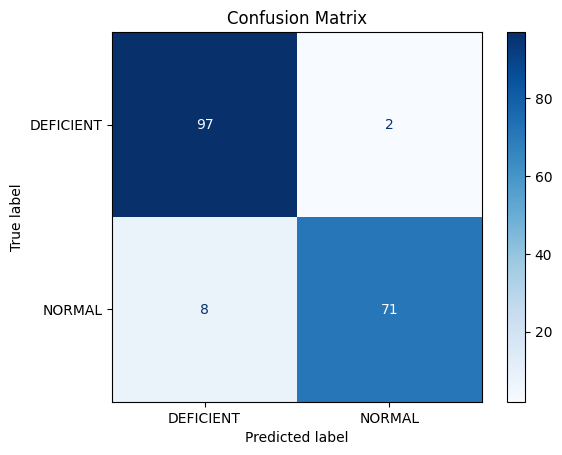

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Function to predict the class of an image
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)
    return predicted_class[0]

# Get the list of test images and their true labels
test_image_paths = []
true_labels = []

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    class_image_paths = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.endswith(('jpg', 'jpeg', 'png'))]
    test_image_paths.extend(class_image_paths)
    true_labels.extend([class_names.index(class_name)] * len(class_image_paths))

# Ensure true_labels and predicted_labels are numpy arrays
true_labels = np.array(true_labels)

# Predict the class for each test image
predicted_labels = [predict_image(model, img_path) for img_path in test_image_paths]
predicted_labels = np.array(predicted_labels)

# Debug prints to verify contents and shapes
print(f"True labels: {true_labels}")
print(f"Predicted labels: {predicted_labels}")
print(f"True labels shape: {true_labels.shape}")
print(f"Predicted labels shape: {predicted_labels.shape}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()